In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa/Dropbox (Princeton)/Research/discrete_sr/code/SPIDER_discrete')

In [3]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [4]:
import netCDF4 as nc

#dataset = 'viscek/N=100000_rho=2.000_v=0.500_alpha=6.000_delta=0.150_t0=10000000_tf=10100000_dt=0.010_T=100_g=0.nc'
#dataset = 'viscek/N=100000_rho=2.000_v=0.500_alpha=6.000_delta=0.200_t0=10000000_tf=10100000_dt=0.010_T=100_g=0.nc'
#dataset = 'viscek/N=100000_rho=2.000_v=0.500_alpha=6.000_delta=0.250_t0=10000000_tf=10100000_dt=0.010_T=100_g=0.nc'
dataset = 'viscek/N=100000_rho=2.000_v=0.500_alpha=6.000_delta=0.300_t0=10000000_tf=10100000_dt=0.010_T=100_g=0.nc'

# (don't interpolate)

ds = nc.Dataset(dataset)
print(ds)

nt = len(ds.dimensions["rec"])
n_particles = len(ds.dimensions["Nv"])
print(nt, n_particles)
deltat = 1
# deltat = 0.01
v = 0.5
positions = np.array(ds.variables["pos"]).T.astype('float64')
positions = np.reshape(positions, (n_particles, 2, nt))
positions -= np.min(positions[:]) # recenter positions to [0, L]
directors = np.array(ds.variables["director"]).astype('float64')
vs = v*np.stack([np.cos(directors), np.sin(directors)], axis=1).T
print(directors.shape)
print(positions.shape)
print(vs.shape)
dims = [np.max(positions[:]), nt]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): rec(1000), Nv(100000), dof(200000), boxdim(4), unit(1)
    variables(dimensions): float64 time(rec, unit), float64 means0(rec, unit), float64 pos(rec, dof), int32 type(rec, Nv), float64 director(rec, Nv), float64 BoxMatrix(rec, boxdim)
    groups: 
1000 100000
(1000, 100000)
(100000, 2, 1000)
(100000, 2, 1000)
[ 223.60679611  223.60679611 1000.        ]


0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


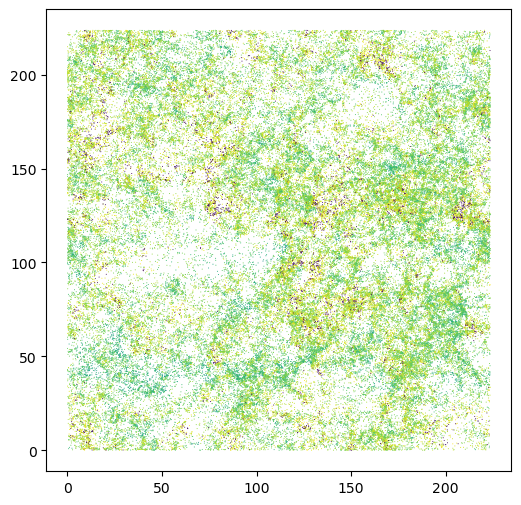

In [44]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

#vid_file = 'viscek/eta0.15_t0.01.mp4'
#vid_file = 'viscek/eta0.2_t0.01.mp4'
#vid_file = 'viscek/eta0.25_t0.01.mp4'
vid_file = 'viscek/eta0.3_t0.01.mp4'


fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [ ]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 25#25 #5
kernel_sigma = corr_L/2.5
cg_res = 1
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 80
dom_time = 50 #previously 20 (without interpolation)
srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*6) #*8
srd.make_weights(m=8, qmax=1)
srd.set_LT_scale(L=corr_L, T=corr_L/v) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

#save('Q_XY_t0.01_eta0.15.npy', srd.dxs, srd.libs)
#save('Q_XY_t0.01_eta0.2.npy', srd.dxs, srd.libs)
#save('Q_XY_t0.01_eta0.25.npy', srd.dxs, srd.libs)
save('Q_XY_t0.01_eta0.3.npy', srd.dxs, srd.libs)

In [ ]:
#_, libs = load('Q_XY_t0.01_eta0.15.npy', 2)
#_, libs = load('Q_XY_t0.01_eta0.2.npy', 2)
#_, libs = load('Q_XY_t0.01_eta0.25.npy', 2)
_, libs = load('Q_XY_t0.01_eta0.3.npy', 2)
libs = libs.item()

In [ ]:
from commons.sparse_reg_bf import *
from identify_models import *
import copy

# for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
scaler0 = Scaler(sub_inds=None, char_sizes=libs[0].col_weights, row_norms=None)
init0 = Initializer(method='combinatorial', start_k=2)
#init0 = Initializer(method='power', start_k=10)
#res0 = Residual(residual_type='fixed_column', anchor_col=0)
res0 = Residual(residual_type='dominant_balance')

iter0 = ModelIterator(max_k=10, backward_forward=True, brute_force=True) # test also boolean toggles
thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)
#thres0 = Threshold(threshold_type='information', ic=AIC)
#thres0 = Threshold(threshold_type='jump', gamma=1.5, n_terms=3)

opts = {'scaler': scaler0, 'initializer': init0, 'residual': res0,
        'model_iterator': iter0, 'threshold': thres0}
opts['verbose'] = False
opts1 = copy.deepcopy(opts) # need to be careful to deep copy for the stateful ModelIterator
opts['inhomog'] = False
opts['inhomog_col'] = None
#opts['verbose'] = False
sub_inds1 = list(range(len(libs[1].terms)))
#sub_inds1.remove(35) # dt rho[v_i * v_j * v_j]
#sub_inds1.remove(21) # rho * dt rho[v_i]
opts1['scaler'] = Scaler(sub_inds=sub_inds1, char_sizes=libs[1].col_weights)
opts1['residual'] = Residual(residual_type='fixed_column', anchor_col=13)
opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)

#opts1['verbose'] = True
opts1['inhomog'] = True
opts1['inhomog_col'] = 13 
    
opts['verbose']=False
opts1['verbose']=False

# note that interleave_identify doesn't work with inhomog or fixed-column residual
opts1['inhomog'] = False
opts1['inhomog_col'] = None
opts1['residual'] = copy.deepcopy(opts['residual'])
opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=None)

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2, experimental=True)

In [ ]:
opts1['inhomog'] = True
opts1['inhomog_col'] = 13 # dt rho[v_i]

remove_terms = [21, 35] # rho * dt rho[v_i], dt rho[v_i * v_j * v_j]
for term in remove_terms:
    if term in opts1['scaler'].sub_inds:
        opts1['scaler'].sub_inds.remove(term) 
opts1['scaler'].reset_inds(opts1['scaler'].sub_inds)

opts1['threshold'] = Threshold(threshold_type='jump', gamma=1.5, n_terms=4)
opts1['verbose'] = False
Xi, lambd, best_term, lambda1 = sparse_reg_bf(libs[1].Q, **opts1)
zipped = [(libs[1].terms[i], c) for i, c in enumerate(Xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])
print(eqn, "; residual:", lambd)

In [ ]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [22]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size, term.complexity)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size, term.complexity)

0 1 1 0
1 rho 2.000000025293657 1
2 dj^2 rho 0.048849751257286744 3
3 dj^2 dk^2 rho 0.00195399005029147 5
4 dt rho 0.12212437814321686 2
5 dt dj^2 rho 0.004884975125728675 4
6 dt^2 rho 0.012212437814321686 3
7 dt^2 dj^2 rho 0.0004884975125728675 5
8 dt^3 rho 0.0012212437814321687 4
9 dt^4 rho 0.00012212437814321687 5
10 rho * rho 4.000000101174629 2
11 rho * dj^2 rho 0.09769950375016234 4
12 rho * dt rho 0.24424875937540586 3
13 rho * dt dj^2 rho 0.009769950375016235 5
14 rho * dt^2 rho 0.024424875937540586 4
15 rho * dt^3 rho 0.0024424875937540586 5
16 dj rho[v_j] 0.03495691833410024 3
17 dj^2 dk rho[v_k] 0.0013982767333640094 5
18 dt dj rho[v_j] 0.0034956918334100237 4
19 dt^2 dj rho[v_j] 0.00034956918334100236 5
20 rho * dj rho[v_j] 0.06991383755238877 4
21 rho * dt dj rho[v_j] 0.006991383755238877 5
22 rho[v_j * v_j] 0.2500000031617072 3
23 dj^2 rho[v_k * v_k] 0.0010006078704318264 5
24 dj dk rho[v_j * v_k] 0.0010006078704318264 5
25 dt rho[v_j * v_j] 0.002501519676079566 4
26 dt^2

In [ ]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['dt rho', 'dj rho[v_j]', 'dt^2 rho', 'dj^2 rho']

#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['1']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

0.02796375863674767 * dj rho[v_i * v_j] + 0.029455641995122378 * dt rho[v_i] + 0.2734631613072339 * dt^2 di rho + 1.0 * dt^3 rho[v_i] + -0.018448087993589445 * rho * dt^2 di rho = 0
frame=10
frame=20
frame=30
frame=40


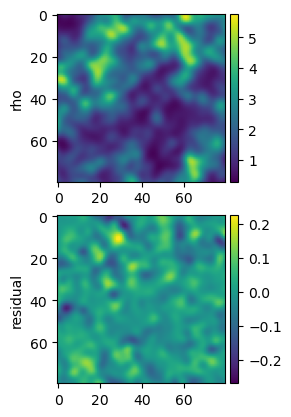

In [32]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viz_test.mp3'

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

def make_all_but_first(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs[1:])[..., 0]

domain = srd.domains[0]
kc = 0 # can select x, y components

print(eqn)

#term1 = srd.libs[1].terms[find_term(libs[1].terms, 'dt rho[v_i]')]
#tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], kc, by_parts=False)[..., 0]
term1 = srd.libs[0].terms[find_term(libs[0].terms, 'rho')]
tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], None, by_parts=False)[..., 0]
fig, (ax1, ax2) = plt.subplots(2, 1)
im1 = ax1.imshow(tw_arr[:, :, len(domain.times)//2])
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)

tw_arr2 = make_residual_arr(eqn, domain, kc) # or 
im2 = ax2.imshow(tw_arr2[:, :, len(domain.times)//2])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)

ax1.set_ylabel(str(term1))
ax2.set_ylabel("residual")

def animate(i):
    if i % 10 == 0:
        print(f"frame={i}")
    im1.set_array(tw_arr[:, :, i])
    im2.set_array(tw_arr2[:, :, i])
    vmax1 = np.max(tw_arr[:, :, i])
    vmin1 = np.min(tw_arr[:, :, i])
    vmax2 = np.max(tw_arr2[:, :, i])
    vmin2 = np.min(tw_arr2[:, :, i])
    #im1.set_clim(vmin1, vmax1)
    #im2.set_clim(vmin2, vmax2)

    return im1, im2

anim = FuncAnimation(fig, animate, np.arange(6, len(domain.times)-6), interval=100, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
#anim.save(vid_file, writer=FFwriter, dpi=100)
HTML(anim.to_html5_video())

#plt.show()

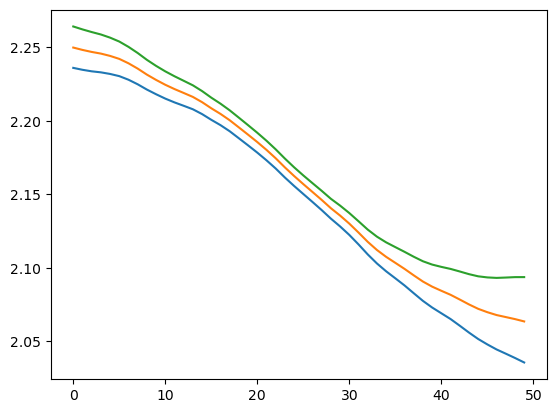

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(tw_arr[0, 0, :])
ax.plot(tw_arr[1, 0, :])
ax.plot(tw_arr[2, 0, :])

In [28]:
def eval_on_Q(Xi, Q):
    return Q @ Xi

print(eval_on_Q(Xi, libs[1].Q))

[ 3.486e-01 -5.480e-01 -6.384e-02  4.979e-01 -1.745e-01 -3.327e-01
  1.923e-01 -2.154e-01  6.062e-01  1.200e-01  3.822e-02  4.876e-01
  6.707e-01  2.095e-01  1.630e-02  1.009e-01  1.664e-01 -1.279e-01
 -1.345e-01  3.551e-01  3.199e-01 -1.948e-01  1.230e-02 -1.979e-01
 -2.319e-01 -4.009e-01 -6.195e-02 -3.634e-01 -3.078e-01  4.955e-02
  1.052e-01 -1.389e-02  5.274e-02 -4.807e-03 -9.451e-03  6.529e-04
  9.604e-02 -1.666e-02  5.082e-03  2.163e-02  3.159e-02  1.855e-03
 -8.978e-03 -3.792e-02  3.222e-02 -6.731e-02 -6.727e-03 -4.971e-02
  1.991e-02 -4.054e-02 -5.191e-03 -5.705e-02 -1.760e-02 -7.820e-03
  3.166e-03 -3.707e-02 -3.332e-02  3.409e-02  4.755e-02  1.240e-02
  5.469e-02  8.743e-03 -1.739e-03 -4.447e-04 -4.860e-02 -5.855e-02
  6.613e-02  1.915e-02 -1.059e-02  7.223e-02 -3.342e-02 -1.806e-02
  3.836e-02 -3.136e-02  4.292e-02 -2.949e-02 -3.812e-02  3.119e-02
 -1.346e-02 -6.683e-02 -1.522e-02 -3.008e-02 -3.841e-02 -3.219e-03
  1.668e-02  4.027e-03  9.288e-03 -2.153e-02 -5.497e-02  3.081

In [11]:
constraint_terms = ['rho', 'rho[v_j * v_j]']
col_numbers = [find_term(libs[0].terms, name) for name in constraint_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 1] -0.25000000000000017 * rho. (Char. size: 2.000000025293657)
[Term 22] 1.0 * rho[v_j * v_j]. (Char. size: 0.2500000031617072)
Model residual: 8.283271158830063e-16


In [12]:
wave_terms = ['dt^2 rho', 'dj^2 rho']
col_numbers = [find_term(libs[0].terms, name) for name in wave_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 2] -0.13484239722442778 * dj^2 rho. (Char. size: 0.048849751257286744)
[Term 6] 1.0 * dt^2 rho. (Char. size: 0.012212437814321686)
Model residual: 0.4630823815284282


In [39]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
#burger_terms = ['dt rho[v_i]', 'rho * dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 13] 1.0 * dt rho[v_i]. (Char. size: 0.025000358369961055)
[Term 24] 0.971667527613842 * dj rho[v_i * v_j]. (Char. size: 0.01043279606946839)
Model residual: 0.29575821103430316


In [14]:
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho', 'dj^2 rho[v_i]']
#euler_terms = ['dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in euler_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] 0.002511222354484635 * di rho. (Char. size: 0.24424875628643372)
[Term 13] 0.9987648071887012 * dt rho[v_i]. (Char. size: 0.01747845916705012)
[Term 24] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.005003039352159132)
Model residual: 0.14552068875769886


In [15]:
toner_tu_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'rho[v_i] * dj rho[v_j]', 'rho[v_i]',
                'di rho', 'dj^2 rho[v_i]', 'di dj rho[v_j]']#, 'dj dk rho[v_i * v_j * v_k]', 
                #'rho * di rho', 'rho * rho * di rho']
# third term is a bit sketchy
col_numbers = [find_term(libs[1].terms, name) for name in toner_tu_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] 0.0038654497762913294 * di rho. (Char. size: 0.24424875628643372)
[Term 10] 0.00023545175394586962 * rho[v_i]. (Char. size: 0.7071067901292057)
[Term 11] 0.2941205541285419 * di dj rho[v_j]. (Char. size: 0.0069913836668200465)
[Term 12] -0.1523119907402973 * dj^2 rho[v_i]. (Char. size: 0.0069913836668200465)
[Term 13] 0.9582763922533301 * dt rho[v_i]. (Char. size: 0.01747845916705012)
[Term 24] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.005003039352159132)
[Term 27] -0.021253094159674035 * rho[v_i] * dj rho[v_j]. (Char. size: 0.0247182743160344)
Model residual: 0.13116340333329035


In [17]:
#inhomog_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
inhomog_terms = ['di rho', 'dj rho[v_i * v_j]', 'dt rho[v_i]', 'rho * di dj^2 rho', 'rho * di rho']
#inhomog_terms = ['dj rho[v_i * v_j]', 'dt dj^2 rho[v_i]', 'dt rho[v_i]', 'dt^3 rho[v_i]']
col_numbers = [find_term(libs[1].terms, name) for name in inhomog_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. \n(Char. size: {libs[1].col_weights[i]}, term contribution: {abs(np.linalg.norm(libs[1].Q[:, i])*Xi[i])})")
print("Model residual:", lambd)

[Term 0] -0.22192253922908747 * di rho. 
(Char. size: 0.24170650638662164, term contribution: 283.8695545426598)
[Term 6] 0.13636269658275846 * rho * di rho. 
(Char. size: 0.4834130188868847, term contribution: 487.7172526471073)
[Term 7] 1.0 * rho * di dj^2 rho. 
(Char. size: 0.019336520755475387, term contribution: 223.62206724071643)
[Term 13] 0.4091255824362579 * dt rho[v_i]. 
(Char. size: 0.017296535575127323, term contribution: 81.00289874997011)
[Term 24] 0.3592635818822717 * dj rho[v_i * v_j]. 
(Char. size: 0.004950965489081333, term contribution: 67.16030772834529)
Model residual: 0.16960275433934077


In [ ]:
noise=0.15 & sigma=2:
1.0 * dj rho[v_i * v_j] + 0.9948015726262622 * dt rho[v_i] = 0 ; residual: 0.08828905387324142
1.0 * dj rho[v_i * v_j] + 0.9939471506601351 * dt rho[v_i] + 
    -0.22223704229705918 * rho * dj rho[v_i * v_j] + 
    -0.2211893091920562 * rho * dt rho[v_i] = 0 ; residual: 0.043201584530243364
1.0 * dj rho[v_i * v_j] + 0.9667146788140899 * dt rho[v_i] 
    + 0.050175235106500286 * rho * di dj^2 rho = 0 ; residual: 0.07982020646775523
-0.030773627406797375 * di rho + 1.0 * dj rho[v_i * v_j] + 0.959319107818593 * dt rho[v_i] + 
    0.10364350002037528 * rho * di dj^2 rho + 0.01299699886926449 * rho * di rho = 0 ; 
    residual: 0.07165680205327109
    
noise=0.2 & sigma=2:
1.0 * dj rho[v_i * v_j] + 0.9890065535710518 * dt rho[v_i] = 0 ; residual: 0.14585171310218614
1.0 * dj rho[v_i * v_j] + 0.9410084749613301 * dt rho[v_i] + 
    -0.2515534627028856 * rho * dj rho[v_i * v_j] + -0.23378824355993344 * rho * dt rho[v_i] = 0 ; 
    residual: 0.09879053083935584
0.1303148677799985 * di dj^2 rho + 0.16323332493962914 * dj rho[v_i * v_j] + 
    1.0 * dt di dj rho[v_j] + 0.16574805811439555 * dt rho[v_i] = 0 ; 
    residual: 0.13484770611457966 ... 
    (note: dj rho[v_j] = -dt rho, so added terms are di [c^2 dj^2 rho-dt^2 rho])
next - di rho, dj rho * rho[v_i * v_j]

(ostrich Burger excluded for below)
noise=0.2 & sigma=10:
0.9458786455927372 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] = 0 ; residual: 0.33837758908171983
0.03068363789601164 * dj rho[v_i * v_j] + 1.0 * dt dj^2 rho[v_i] + 
    0.04195556069398009 * dt rho[v_i] = 0 ; residual: 0.29280537425594955
0.03463015539080773 * dj rho[v_i * v_j] + 1.0 * dt dj^2 rho[v_i] + 
0.04903700783398734 * dt rho[v_i] + 0.8962787525864214 * dt^3 rho[v_i] = 0 ; residual: 0.25781215262937246

noise=0.25 & sigma=2:
0.9588624711502879 * dj rho[v_i * v_j] + 1.0 * dt rho[v_i] = 0 ; residual: 0.2954829093027145
0.030330190808319463 * dj rho[v_i * v_j] + 0.033059127515027716 * dt rho[v_i] 
    + 1.0 * dt^3 rho[v_i] = 0 ; residual: 0.18168407469370618
0.029388332917047028 * dj rho[v_i * v_j] + 0.029687032525948016 * dt rho[v_i] 
    + 0.24234604931453602 * dt^2 di rho + 1.0 * dt^3 rho[v_i] = 0 ; residual: 0.1635690777625245
(no further large residual drop at n=5)

noise=0.3 & sigma=2:
1.0 * dj rho[v_i * v_j] + 0.9633919417912252 * dt rho[v_i] = 0 ; residual: 0.2540783388093272
0.04669217020032154 * dj rho[v_i * v_j] + 0.04783989495830139 * dt rho[v_i] + 
    1.0 * dt^3 rho[v_i] = 0 ; residual: 0.19618577400565984
0.040638873055770804 * dj rho[v_i * v_j] + 0.04529437117483896 * dt rho[v_i] + 
    1.0 * dt^3 rho[v_i] + 0.0002852024309517627 * rho * di rho = 0 ; residual: 0.18756206767941766
0.040317473161512844 * dj rho[v_i * v_j] + 0.04123561275147303 * dt rho[v_i] + 
    1.0 * dt^3 rho[v_i] + 0.00019078016530789968 * rho * di rho 
    + -0.0011627939978262939 * rho[v_j] * dj rho[v_i] = 0 ; residual: 0.1841704140250431

